https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [7]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [8]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [9]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [2, 4, 3])

In [10]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [11]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [12]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [13]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [14]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [15]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

In [16]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("8_resnet_2_4_3_inchannels_64.csv", train_losses, train_acc, test_losses, test_acc)


EPOCHS : 0


Batch_id=87 Batch Loss=1.3026342391967773 Running Loss=141.83315289020538 Running Accuracy=40.93: 100%|██████████| 88/88 [00:41<00:00,  2.11it/s]



Validation set: Average loss: 0.0027, Accuracy: 2561/5000 (51.22%)


Test set: Average loss: 1.3482, Accuracy: 5132/10000 (51.32%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.0655760765075684 Running Loss=101.83450788259506 Running Accuracy=58.38: 100%|██████████| 88/88 [00:43<00:00,  2.03it/s]



Validation set: Average loss: 0.0024, Accuracy: 3010/5000 (60.20%)


Test set: Average loss: 1.1680, Accuracy: 5974/10000 (59.74%)

EPOCHS : 2


Batch_id=87 Batch Loss=0.9061462879180908 Running Loss=81.41980081796646 Running Accuracy=67.17: 100%|██████████| 88/88 [00:46<00:00,  1.88it/s]



Validation set: Average loss: 0.0017, Accuracy: 3513/5000 (70.26%)


Test set: Average loss: 0.8906, Accuracy: 6880/10000 (68.80%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.7559066414833069 Running Loss=70.29121881723404 Running Accuracy=71.88: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0017, Accuracy: 3528/5000 (70.56%)


Test set: Average loss: 0.8807, Accuracy: 7069/10000 (70.69%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.6943268179893494 Running Loss=61.663304805755615 Running Accuracy=75.48: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0014, Accuracy: 3866/5000 (77.32%)


Test set: Average loss: 0.6885, Accuracy: 7698/10000 (76.98%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.6592807173728943 Running Loss=55.768462777137756 Running Accuracy=77.94: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0014, Accuracy: 3797/5000 (75.94%)


Test set: Average loss: 0.7627, Accuracy: 7485/10000 (74.85%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.5630483627319336 Running Loss=51.32277208566666 Running Accuracy=79.66: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0012, Accuracy: 4009/5000 (80.18%)


Test set: Average loss: 0.6090, Accuracy: 7932/10000 (79.32%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.5883183479309082 Running Loss=47.84094628691673 Running Accuracy=81.04: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0011, Accuracy: 4123/5000 (82.46%)


Test set: Average loss: 0.5576, Accuracy: 8171/10000 (81.71%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.4488646984100342 Running Loss=44.251978904008865 Running Accuracy=82.33: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0010, Accuracy: 4141/5000 (82.82%)


Test set: Average loss: 0.5451, Accuracy: 8148/10000 (81.48%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.48558568954467773 Running Loss=41.59191158413887 Running Accuracy=83.48: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0012, Accuracy: 4025/5000 (80.50%)


Test set: Average loss: 0.6107, Accuracy: 8056/10000 (80.56%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.4339742362499237 Running Loss=39.512542217969894 Running Accuracy=84.08: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0010, Accuracy: 4152/5000 (83.04%)


Test set: Average loss: 0.5094, Accuracy: 8317/10000 (83.17%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.430716872215271 Running Loss=36.891684889793396 Running Accuracy=85.29: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0012, Accuracy: 4009/5000 (80.18%)


Test set: Average loss: 0.6433, Accuracy: 7949/10000 (79.49%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.35640352964401245 Running Loss=34.830849558115005 Running Accuracy=86.18: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0012, Accuracy: 4068/5000 (81.36%)


Test set: Average loss: 0.6207, Accuracy: 8044/10000 (80.44%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.32860976457595825 Running Loss=33.141071647405624 Running Accuracy=86.70: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4229/5000 (84.58%)


Test set: Average loss: 0.4843, Accuracy: 8446/10000 (84.46%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.32461923360824585 Running Loss=32.02491647005081 Running Accuracy=87.19: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4260/5000 (85.20%)


Test set: Average loss: 0.4718, Accuracy: 8449/10000 (84.49%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.3428543210029602 Running Loss=30.609753474593163 Running Accuracy=87.83: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4244/5000 (84.88%)


Test set: Average loss: 0.4691, Accuracy: 8418/10000 (84.18%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.37025824189186096 Running Loss=29.401733696460724 Running Accuracy=88.32: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0010, Accuracy: 4205/5000 (84.10%)


Test set: Average loss: 0.5034, Accuracy: 8427/10000 (84.27%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.2803267240524292 Running Loss=28.000848948955536 Running Accuracy=88.70: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4341/5000 (86.82%)


Test set: Average loss: 0.4496, Accuracy: 8536/10000 (85.36%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.3060428202152252 Running Loss=26.349131643772125 Running Accuracy=89.41: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4329/5000 (86.58%)


Test set: Average loss: 0.4442, Accuracy: 8599/10000 (85.99%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.3788161277770996 Running Loss=25.21545046567917 Running Accuracy=89.80: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0008, Accuracy: 4339/5000 (86.78%)


Test set: Average loss: 0.4276, Accuracy: 8598/10000 (85.98%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.3129217326641083 Running Loss=24.483189433813095 Running Accuracy=90.17: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4303/5000 (86.06%)


Test set: Average loss: 0.4301, Accuracy: 8609/10000 (86.09%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.2408805936574936 Running Loss=22.51693929731846 Running Accuracy=90.94: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4251/5000 (85.02%)


Test set: Average loss: 0.4690, Accuracy: 8512/10000 (85.12%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.24964900314807892 Running Loss=22.399624407291412 Running Accuracy=90.87: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4265/5000 (85.30%)


Test set: Average loss: 0.4965, Accuracy: 8472/10000 (84.72%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.3190872371196747 Running Loss=20.925071239471436 Running Accuracy=91.61: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0008, Accuracy: 4388/5000 (87.76%)


Test set: Average loss: 0.4171, Accuracy: 8729/10000 (87.29%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.2561021149158478 Running Loss=20.92776320874691 Running Accuracy=91.50: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4407/5000 (88.14%)


Test set: Average loss: 0.3907, Accuracy: 8774/10000 (87.74%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.25622931122779846 Running Loss=20.003806084394455 Running Accuracy=91.91: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3967, Accuracy: 8810/10000 (88.10%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.2593127489089966 Running Loss=18.89530546963215 Running Accuracy=92.27: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4409/5000 (88.18%)


Test set: Average loss: 0.4205, Accuracy: 8721/10000 (87.21%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.19440549612045288 Running Loss=17.874449595808983 Running Accuracy=92.76: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4445/5000 (88.90%)


Test set: Average loss: 0.3820, Accuracy: 8816/10000 (88.16%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.19395293295383453 Running Loss=17.188915714621544 Running Accuracy=93.19: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0010, Accuracy: 4260/5000 (85.20%)


Test set: Average loss: 0.5311, Accuracy: 8440/10000 (84.40%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.20274454355239868 Running Loss=16.48752960562706 Running Accuracy=93.30: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4336/5000 (86.72%)


Test set: Average loss: 0.4761, Accuracy: 8638/10000 (86.38%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.23135751485824585 Running Loss=16.384023427963257 Running Accuracy=93.38: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4406/5000 (88.12%)


Test set: Average loss: 0.4055, Accuracy: 8758/10000 (87.58%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.20473982393741608 Running Loss=15.433836713433266 Running Accuracy=93.77: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4373/5000 (87.46%)


Test set: Average loss: 0.4396, Accuracy: 8651/10000 (86.51%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.16734649240970612 Running Loss=14.708011664450169 Running Accuracy=94.07: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4426/5000 (88.52%)


Test set: Average loss: 0.3919, Accuracy: 8832/10000 (88.32%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.15129807591438293 Running Loss=14.075471177697182 Running Accuracy=94.25: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4375/5000 (87.50%)


Test set: Average loss: 0.4369, Accuracy: 8757/10000 (87.57%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.17105819284915924 Running Loss=14.873145401477814 Running Accuracy=93.89: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4357/5000 (87.14%)


Test set: Average loss: 0.4804, Accuracy: 8687/10000 (86.87%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.17951001226902008 Running Loss=13.28392668813467 Running Accuracy=94.51: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4454/5000 (89.08%)


Test set: Average loss: 0.3839, Accuracy: 8868/10000 (88.68%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.14657139778137207 Running Loss=13.10165672749281 Running Accuracy=94.70: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0008, Accuracy: 4435/5000 (88.70%)


Test set: Average loss: 0.3994, Accuracy: 8895/10000 (88.95%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.12978442013263702 Running Loss=12.275576993823051 Running Accuracy=95.03: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4386/5000 (87.72%)


Test set: Average loss: 0.4623, Accuracy: 8659/10000 (86.59%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.12193818390369415 Running Loss=11.965285308659077 Running Accuracy=95.22: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4378/5000 (87.56%)


Test set: Average loss: 0.4838, Accuracy: 8659/10000 (86.59%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.1267213374376297 Running Loss=11.971237555146217 Running Accuracy=95.05: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4360/5000 (87.20%)


Test set: Average loss: 0.4680, Accuracy: 8715/10000 (87.15%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.11584887653589249 Running Loss=11.17170362919569 Running Accuracy=95.56: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4388/5000 (87.76%)


Test set: Average loss: 0.4717, Accuracy: 8721/10000 (87.21%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.1131228506565094 Running Loss=11.153933800756931 Running Accuracy=95.48: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0008, Accuracy: 4444/5000 (88.88%)


Test set: Average loss: 0.4161, Accuracy: 8863/10000 (88.63%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.09344815462827682 Running Loss=10.661332912743092 Running Accuracy=95.68: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4399/5000 (87.98%)


Test set: Average loss: 0.4434, Accuracy: 8784/10000 (87.84%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.13434451818466187 Running Loss=10.15209947526455 Running Accuracy=95.88: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4449/5000 (88.98%)


Test set: Average loss: 0.4223, Accuracy: 8833/10000 (88.33%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.14890046417713165 Running Loss=9.630962423980236 Running Accuracy=96.02: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4430/5000 (88.60%)


Test set: Average loss: 0.4505, Accuracy: 8817/10000 (88.17%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.15335002541542053 Running Loss=9.227747894823551 Running Accuracy=96.29: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0008, Accuracy: 4429/5000 (88.58%)


Test set: Average loss: 0.4207, Accuracy: 8858/10000 (88.58%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.10099635273218155 Running Loss=9.286622144281864 Running Accuracy=96.25: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0008, Accuracy: 4488/5000 (89.76%)


Test set: Average loss: 0.3955, Accuracy: 8928/10000 (89.28%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.14464052021503448 Running Loss=9.307762268930674 Running Accuracy=96.19: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0011, Accuracy: 4324/5000 (86.48%)


Test set: Average loss: 0.5326, Accuracy: 8659/10000 (86.59%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.09652478247880936 Running Loss=8.696509044617414 Running Accuracy=96.44: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.4557, Accuracy: 8813/10000 (88.13%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.0794776976108551 Running Loss=8.421167232096195 Running Accuracy=96.49: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4428/5000 (88.56%)


Test set: Average loss: 0.4606, Accuracy: 8788/10000 (87.88%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.09865428507328033 Running Loss=8.174423974007368 Running Accuracy=96.70: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.4750, Accuracy: 8805/10000 (88.05%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.12114162743091583 Running Loss=8.120163138955832 Running Accuracy=96.79: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0008, Accuracy: 4454/5000 (89.08%)


Test set: Average loss: 0.4164, Accuracy: 8960/10000 (89.60%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.1305573582649231 Running Loss=8.239414032548666 Running Accuracy=96.63: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4448/5000 (88.96%)


Test set: Average loss: 0.4702, Accuracy: 8789/10000 (87.89%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.09578180313110352 Running Loss=7.709273736923933 Running Accuracy=96.91: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.4810, Accuracy: 8763/10000 (87.63%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.12536413967609406 Running Loss=7.818733114749193 Running Accuracy=96.86: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0010, Accuracy: 4406/5000 (88.12%)


Test set: Average loss: 0.4955, Accuracy: 8788/10000 (87.88%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.10369191318750381 Running Loss=7.223438855260611 Running Accuracy=97.13: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4465/5000 (89.30%)


Test set: Average loss: 0.4638, Accuracy: 8882/10000 (88.82%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.06966976076364517 Running Loss=6.542059816420078 Running Accuracy=97.32: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4480/5000 (89.60%)


Test set: Average loss: 0.4203, Accuracy: 8918/10000 (89.18%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.05510391294956207 Running Loss=6.780004370957613 Running Accuracy=97.27: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4525/5000 (90.50%)


Test set: Average loss: 0.3590, Accuracy: 9025/10000 (90.25%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.08184181153774261 Running Loss=6.4845923110842705 Running Accuracy=97.43: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4482/5000 (89.64%)


Test set: Average loss: 0.4572, Accuracy: 8893/10000 (88.93%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.07238002121448517 Running Loss=6.346969619393349 Running Accuracy=97.40: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4479/5000 (89.58%)


Test set: Average loss: 0.4222, Accuracy: 8949/10000 (89.49%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.07118319720029831 Running Loss=6.110079940408468 Running Accuracy=97.52: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4535/5000 (90.70%)


Test set: Average loss: 0.3881, Accuracy: 9026/10000 (90.26%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.08566239476203918 Running Loss=5.807079166173935 Running Accuracy=97.75: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4532/5000 (90.64%)


Test set: Average loss: 0.3888, Accuracy: 9013/10000 (90.13%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.05543326959013939 Running Loss=5.703441396355629 Running Accuracy=97.71: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4465/5000 (89.30%)


Test set: Average loss: 0.4355, Accuracy: 8896/10000 (88.96%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.09567037224769592 Running Loss=6.445263348519802 Running Accuracy=97.34: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4451/5000 (89.02%)


Test set: Average loss: 0.4551, Accuracy: 8895/10000 (88.95%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.0572727769613266 Running Loss=5.771714460104704 Running Accuracy=97.70: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4516/5000 (90.32%)


Test set: Average loss: 0.3788, Accuracy: 9064/10000 (90.64%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.07944013923406601 Running Loss=5.431772576645017 Running Accuracy=97.92: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0010, Accuracy: 4407/5000 (88.14%)


Test set: Average loss: 0.4890, Accuracy: 8850/10000 (88.50%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.07991982251405716 Running Loss=5.3588883355259895 Running Accuracy=97.91: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0008, Accuracy: 4526/5000 (90.52%)


Test set: Average loss: 0.3887, Accuracy: 9022/10000 (90.22%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.06679808348417282 Running Loss=4.989521993324161 Running Accuracy=98.12: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0010, Accuracy: 4443/5000 (88.86%)


Test set: Average loss: 0.4680, Accuracy: 8911/10000 (89.11%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.06262651830911636 Running Loss=4.768711254000664 Running Accuracy=98.12: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4488/5000 (89.76%)


Test set: Average loss: 0.4413, Accuracy: 8923/10000 (89.23%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.08560177683830261 Running Loss=5.420072712004185 Running Accuracy=97.84: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4485/5000 (89.70%)


Test set: Average loss: 0.4209, Accuracy: 8949/10000 (89.49%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.05835938826203346 Running Loss=5.392358332872391 Running Accuracy=97.93: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4468/5000 (89.36%)


Test set: Average loss: 0.4649, Accuracy: 8934/10000 (89.34%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.06451147049665451 Running Loss=4.955422319471836 Running Accuracy=98.10: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4489/5000 (89.78%)

Epoch 00072: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.4401, Accuracy: 8950/10000 (89.50%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.03172754496335983 Running Loss=3.257968669757247 Running Accuracy=98.80: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4596/5000 (91.92%)


Test set: Average loss: 0.3427, Accuracy: 9121/10000 (91.21%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.019788388162851334 Running Loss=2.442039812915027 Running Accuracy=99.13: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4606/5000 (92.12%)


Test set: Average loss: 0.3302, Accuracy: 9146/10000 (91.46%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.024135485291481018 Running Loss=2.039953501429409 Running Accuracy=99.33: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4611/5000 (92.22%)


Test set: Average loss: 0.3268, Accuracy: 9144/10000 (91.44%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.019263600930571556 Running Loss=1.974366296082735 Running Accuracy=99.32: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4609/5000 (92.18%)


Test set: Average loss: 0.3256, Accuracy: 9157/10000 (91.57%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.02580162137746811 Running Loss=1.8450286472216249 Running Accuracy=99.36: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4613/5000 (92.26%)


Test set: Average loss: 0.3268, Accuracy: 9168/10000 (91.68%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.013837297447025776 Running Loss=1.7315300470218062 Running Accuracy=99.42: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4613/5000 (92.26%)


Test set: Average loss: 0.3230, Accuracy: 9174/10000 (91.74%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.019803235307335854 Running Loss=1.6791940168477595 Running Accuracy=99.42: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4606/5000 (92.12%)


Test set: Average loss: 0.3241, Accuracy: 9171/10000 (91.71%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.019527914002537727 Running Loss=1.610361525323242 Running Accuracy=99.49: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4615/5000 (92.30%)


Test set: Average loss: 0.3243, Accuracy: 9169/10000 (91.69%)

EPOCHS : 80


Batch_id=87 Batch Loss=0.020285246893763542 Running Loss=1.5895320298150182 Running Accuracy=99.49: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4620/5000 (92.40%)


Test set: Average loss: 0.3259, Accuracy: 9165/10000 (91.65%)

EPOCHS : 81


Batch_id=87 Batch Loss=0.02230088599026203 Running Loss=1.5031864303164184 Running Accuracy=99.51: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4606/5000 (92.12%)


Test set: Average loss: 0.3259, Accuracy: 9179/10000 (91.79%)

EPOCHS : 82


Batch_id=87 Batch Loss=0.0073083979077637196 Running Loss=1.5161027810536325 Running Accuracy=99.49: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4608/5000 (92.16%)


Test set: Average loss: 0.3244, Accuracy: 9174/10000 (91.74%)

EPOCHS : 83


Batch_id=87 Batch Loss=0.017992448061704636 Running Loss=1.5088342614471912 Running Accuracy=99.54: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4606/5000 (92.12%)


Test set: Average loss: 0.3242, Accuracy: 9172/10000 (91.72%)

EPOCHS : 84


Batch_id=87 Batch Loss=0.011383461765944958 Running Loss=1.3588907634839416 Running Accuracy=99.59: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4608/5000 (92.16%)


Test set: Average loss: 0.3234, Accuracy: 9162/10000 (91.62%)

EPOCHS : 85


Batch_id=87 Batch Loss=0.020870612934231758 Running Loss=1.5123350070789456 Running Accuracy=99.51: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4609/5000 (92.18%)


Test set: Average loss: 0.3234, Accuracy: 9188/10000 (91.88%)

EPOCHS : 86


Batch_id=87 Batch Loss=0.01013471931219101 Running Loss=1.3736681817099452 Running Accuracy=99.60: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4616/5000 (92.32%)


Test set: Average loss: 0.3272, Accuracy: 9161/10000 (91.61%)

EPOCHS : 87


Batch_id=87 Batch Loss=0.011272267438471317 Running Loss=1.3753621699288487 Running Accuracy=99.57: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4620/5000 (92.40%)

Epoch 00088: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.3243, Accuracy: 9181/10000 (91.81%)

EPOCHS : 88


Batch_id=87 Batch Loss=0.013697158545255661 Running Loss=1.3276146007701755 Running Accuracy=99.61: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4618/5000 (92.36%)


Test set: Average loss: 0.3237, Accuracy: 9180/10000 (91.80%)

EPOCHS : 89


Batch_id=87 Batch Loss=0.01254939753562212 Running Loss=1.2601660452783108 Running Accuracy=99.62: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4617/5000 (92.34%)


Test set: Average loss: 0.3231, Accuracy: 9171/10000 (91.71%)

EPOCHS : 90


Batch_id=87 Batch Loss=0.011121101677417755 Running Loss=1.256890838034451 Running Accuracy=99.62: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4614/5000 (92.28%)


Test set: Average loss: 0.3222, Accuracy: 9178/10000 (91.78%)

EPOCHS : 91


Batch_id=87 Batch Loss=0.018895333632826805 Running Loss=1.261097612325102 Running Accuracy=99.63: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4616/5000 (92.32%)


Test set: Average loss: 0.3226, Accuracy: 9176/10000 (91.76%)

EPOCHS : 92


Batch_id=87 Batch Loss=0.012430069036781788 Running Loss=1.3010299759916961 Running Accuracy=99.60: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4617/5000 (92.34%)


Test set: Average loss: 0.3234, Accuracy: 9173/10000 (91.73%)

EPOCHS : 93


Batch_id=87 Batch Loss=0.01546457875519991 Running Loss=1.1948419781401753 Running Accuracy=99.64: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4618/5000 (92.36%)


Test set: Average loss: 0.3247, Accuracy: 9174/10000 (91.74%)

EPOCHS : 94


Batch_id=87 Batch Loss=0.01782870478928089 Running Loss=1.3002008660696447 Running Accuracy=99.58: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4621/5000 (92.42%)


Test set: Average loss: 0.3239, Accuracy: 9178/10000 (91.78%)

EPOCHS : 95


Batch_id=87 Batch Loss=0.015539946034550667 Running Loss=1.273537137079984 Running Accuracy=99.59: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4621/5000 (92.42%)


Test set: Average loss: 0.3231, Accuracy: 9177/10000 (91.77%)

EPOCHS : 96


Batch_id=87 Batch Loss=0.00945343915373087 Running Loss=1.2478334410116076 Running Accuracy=99.62: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4620/5000 (92.40%)

Epoch 00097: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 0.3231, Accuracy: 9178/10000 (91.78%)

EPOCHS : 97


Batch_id=87 Batch Loss=0.014892004430294037 Running Loss=1.2944853277876973 Running Accuracy=99.60: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4620/5000 (92.40%)


Test set: Average loss: 0.3236, Accuracy: 9176/10000 (91.76%)

EPOCHS : 98


Batch_id=87 Batch Loss=0.01334778219461441 Running Loss=1.2786706378683448 Running Accuracy=99.62: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4621/5000 (92.42%)


Test set: Average loss: 0.3236, Accuracy: 9177/10000 (91.77%)

EPOCHS : 99


Batch_id=87 Batch Loss=0.011996559798717499 Running Loss=1.21878104750067 Running Accuracy=99.65: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4620/5000 (92.40%)

Epoch 00100: reducing learning rate of group 0 to 1.0000e-06.

Test set: Average loss: 0.3225, Accuracy: 9183/10000 (91.83%)

EPOCHS : 100


Batch_id=87 Batch Loss=0.01010438334196806 Running Loss=1.26868313876912 Running Accuracy=99.64: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4620/5000 (92.40%)


Test set: Average loss: 0.3224, Accuracy: 9181/10000 (91.81%)

EPOCHS : 101


Batch_id=87 Batch Loss=0.014605927281081676 Running Loss=1.2767426865175366 Running Accuracy=99.58: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4618/5000 (92.36%)


Test set: Average loss: 0.3230, Accuracy: 9179/10000 (91.79%)

EPOCHS : 102


Batch_id=87 Batch Loss=0.019365733489394188 Running Loss=1.3312429920770228 Running Accuracy=99.57: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4618/5000 (92.36%)

Epoch 00103: reducing learning rate of group 0 to 1.0000e-07.

Test set: Average loss: 0.3227, Accuracy: 9174/10000 (91.74%)

EPOCHS : 103


Batch_id=87 Batch Loss=0.016987325623631477 Running Loss=1.233614840079099 Running Accuracy=99.63: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4619/5000 (92.38%)


Test set: Average loss: 0.3234, Accuracy: 9175/10000 (91.75%)

EPOCHS : 104


Batch_id=87 Batch Loss=0.012697305530309677 Running Loss=1.1833485937677324 Running Accuracy=99.65: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4619/5000 (92.38%)


Test set: Average loss: 0.3228, Accuracy: 9183/10000 (91.83%)

EPOCHS : 105


Batch_id=87 Batch Loss=0.00625190045684576 Running Loss=1.233530172612518 Running Accuracy=99.61: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4623/5000 (92.46%)


Test set: Average loss: 0.3239, Accuracy: 9175/10000 (91.75%)

EPOCHS : 106


Batch_id=87 Batch Loss=0.01860770210623741 Running Loss=1.2878293711692095 Running Accuracy=99.61: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4619/5000 (92.38%)


Test set: Average loss: 0.3227, Accuracy: 9179/10000 (91.79%)

EPOCHS : 107


Batch_id=87 Batch Loss=0.012134633958339691 Running Loss=1.3326758821494877 Running Accuracy=99.58: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4621/5000 (92.42%)

Epoch 00108: reducing learning rate of group 0 to 1.0000e-08.

Test set: Average loss: 0.3238, Accuracy: 9179/10000 (91.79%)

EPOCHS : 108


Batch_id=87 Batch Loss=0.014158027246594429 Running Loss=1.3006300083361566 Running Accuracy=99.59: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4617/5000 (92.34%)


Test set: Average loss: 0.3228, Accuracy: 9176/10000 (91.76%)

EPOCHS : 109


Batch_id=87 Batch Loss=0.015897559002041817 Running Loss=1.2754680048674345 Running Accuracy=99.58: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4617/5000 (92.34%)


Test set: Average loss: 0.3226, Accuracy: 9182/10000 (91.82%)

EPOCHS : 110


Batch_id=87 Batch Loss=0.017958780750632286 Running Loss=1.1751812929287553 Running Accuracy=99.66: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4617/5000 (92.34%)


Test set: Average loss: 0.3226, Accuracy: 9179/10000 (91.79%)

EPOCHS : 111


Batch_id=87 Batch Loss=0.031699080020189285 Running Loss=1.2668656432069838 Running Accuracy=99.61: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4623/5000 (92.46%)


Test set: Average loss: 0.3235, Accuracy: 9179/10000 (91.79%)

EPOCHS : 112


Batch_id=87 Batch Loss=0.02740566059947014 Running Loss=1.2027955036610365 Running Accuracy=99.62: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4619/5000 (92.38%)


Test set: Average loss: 0.3222, Accuracy: 9176/10000 (91.76%)

EPOCHS : 113


Batch_id=87 Batch Loss=0.025949573144316673 Running Loss=1.3675027177669108 Running Accuracy=99.57: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4618/5000 (92.36%)


Test set: Average loss: 0.3229, Accuracy: 9181/10000 (91.81%)

EPOCHS : 114


Batch_id=87 Batch Loss=0.014780841767787933 Running Loss=1.2308724806644022 Running Accuracy=99.62: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4618/5000 (92.36%)


Test set: Average loss: 0.3234, Accuracy: 9179/10000 (91.79%)

EPOCHS : 115


Batch_id=87 Batch Loss=0.010054913349449635 Running Loss=1.1639772448688745 Running Accuracy=99.65: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4622/5000 (92.44%)


Test set: Average loss: 0.3237, Accuracy: 9178/10000 (91.78%)

EPOCHS : 116


Batch_id=87 Batch Loss=0.019870003685355186 Running Loss=1.3515592906624079 Running Accuracy=99.61: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4617/5000 (92.34%)


Test set: Average loss: 0.3227, Accuracy: 9180/10000 (91.80%)

EPOCHS : 117


Batch_id=87 Batch Loss=0.022061776369810104 Running Loss=1.2356419493444264 Running Accuracy=99.64: 100%|██████████| 88/88 [00:46<00:00,  1.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4616/5000 (92.32%)


Test set: Average loss: 0.3231, Accuracy: 9180/10000 (91.80%)

EPOCHS : 118


Batch_id=87 Batch Loss=0.01198815368115902 Running Loss=1.3445592150092125 Running Accuracy=99.58: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4622/5000 (92.44%)


Test set: Average loss: 0.3236, Accuracy: 9179/10000 (91.79%)

EPOCHS : 119


Batch_id=87 Batch Loss=0.018663501366972923 Running Loss=1.2333864066749811 Running Accuracy=99.63: 100%|██████████| 88/88 [00:46<00:00,  1.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4621/5000 (92.42%)


Test set: Average loss: 0.3223, Accuracy: 9182/10000 (91.82%)



In [22]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model1, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.3241, Accuracy: 9171/10000 (91.71%)


Test set: Average loss: 0.3234, Accuracy: 9188/10000 (91.88%)



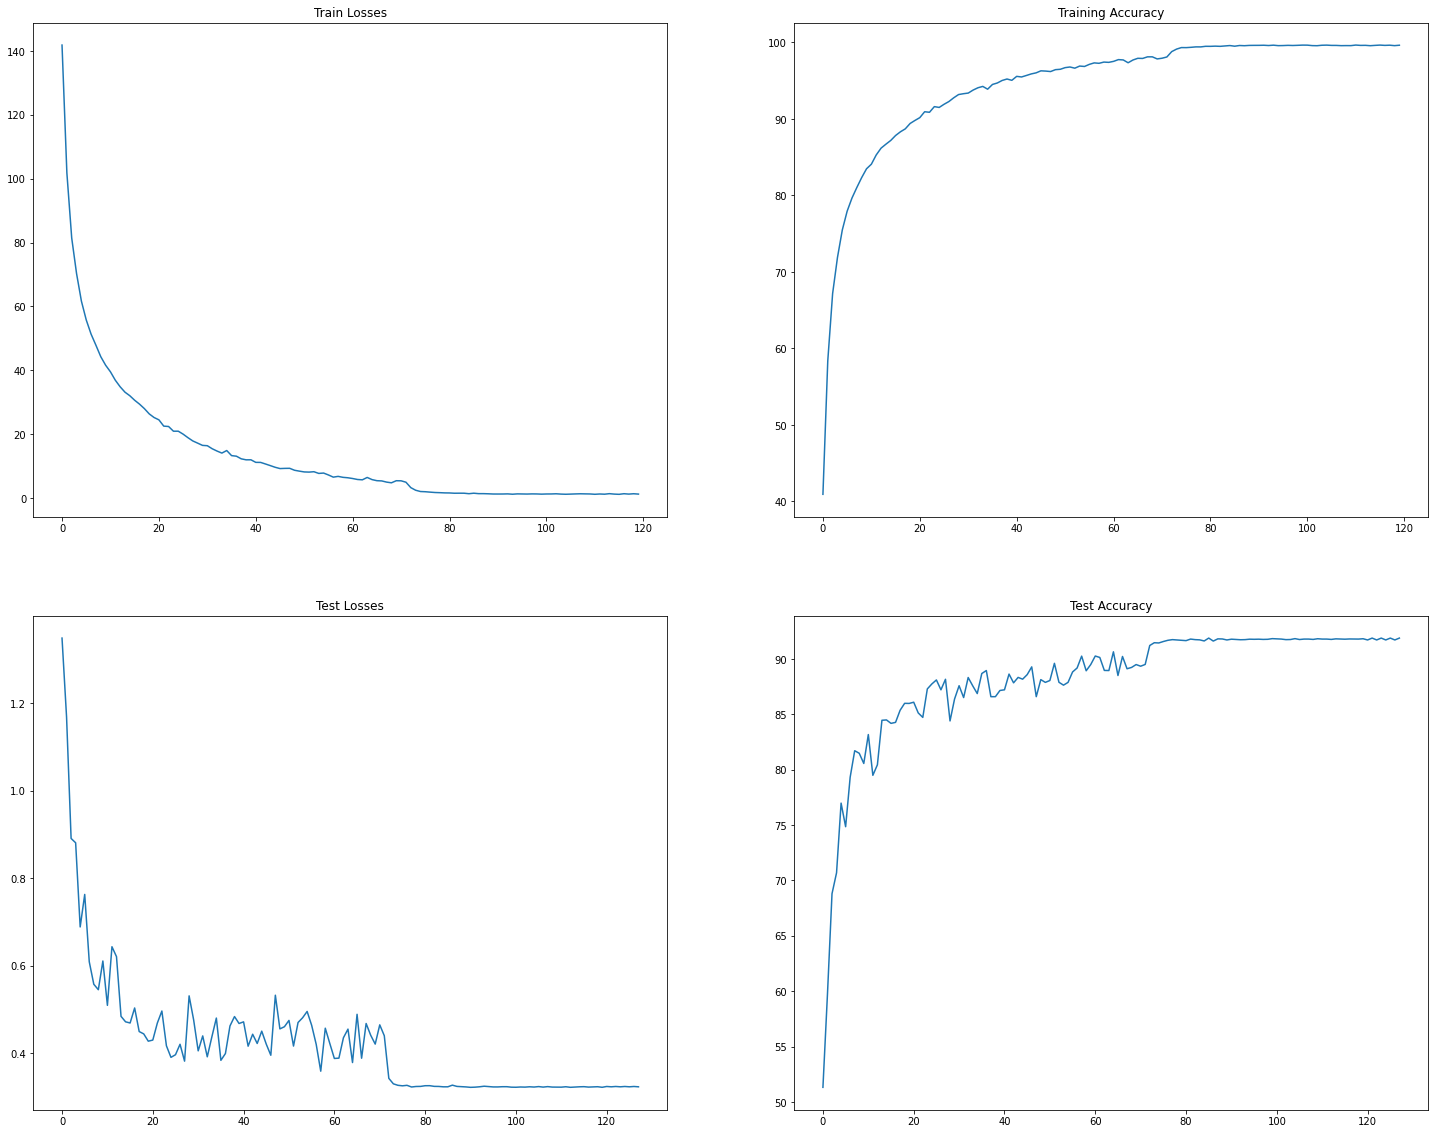

In [23]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)